In [1]:
# 05_matchup_predictor.ipynb
# 🏈 Simple Game Outcome Predictor Using EPA & Success Rate

# 🛠 Requirements:
# - pandas, scikit-learn, matplotlib, seaborn (install via `pip install pandas scikit-learn matplotlib seaborn`)

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os

DATA_DIR = "./data"

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]


In [2]:
# 📂 Load 2023 game results and season stats

games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))
stats = pd.read_csv(os.path.join(DATA_DIR, "advanced_season_stats", "2023.csv"))

# Filter to FBS-only matchups where both teams have data
games_2023 = games[(games["season"] == 2023) & (games["home_classification"] == 'fbs') & (games["away_classification"] == 'fbs')]
print(f"{len(games_2023)} FBS vs. FBS games in 2023")

792 FBS vs. FBS games in 2023


/tmp/ipykernel_86692/604763447.py:3: DtypeWarning: Columns (5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))


In [3]:
# 🔗 Join game data with team stats for both teams

# Prep stats
stats = stats[["team", "offense_ppa", "defense_ppa", "offense_successRate", "defense_successRate"]].copy()

# Merge home/away team stats
games_stats = games_2023.merge(stats, left_on="home_team", right_on="team", how="inner").rename(columns={
    "offense_ppa": "home_offense_ppa", "defense_ppa": "home_defense_ppa",
    "offense_successRate": "home_offense_successRate", "defense_successRate": "home_defense_successRate"
}).drop("team", axis=1)

games_stats = games_stats.merge(stats, left_on="away_team", right_on="team", how="inner").rename(columns={
    "offense_ppa": "away_offense_ppa", "defense_ppa": "away_defense_ppa",
    "offense_successRate": "away_offense_successRate", "defense_successRate": "away_defense_successRate"
}).drop("team", axis=1)

print(f"{len(games_stats)} games with full stat coverage")


792 games with full stat coverage


In [4]:
# 🧠 Feature engineering: create stat differentials

games_stats["ppa_diff"] = games_stats["home_offense_ppa"] - games_stats["away_defense_ppa"]
games_stats["ppa_allowed_diff"] = games_stats["home_defense_ppa"] - games_stats["away_offense_ppa"]
games_stats["successRate_diff"] = games_stats["home_offense_successRate"] - games_stats["away_defense_successRate"]
games_stats["successRate_allowed_diff"] = games_stats["home_defense_successRate"] - games_stats["away_offense_successRate"]

# Target: did home team win?
games_stats["home_win"] = (games_stats["home_points"] > games_stats["away_points"]).astype(int)

feature_cols = ["ppa_diff", "ppa_allowed_diff", "successRate_diff", "successRate_allowed_diff"]
X = games_stats[feature_cols]
y = games_stats["home_win"]


In [5]:
# 🤖 Train/test split and model training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {acc:.2%}")


Model Accuracy: 55.35%


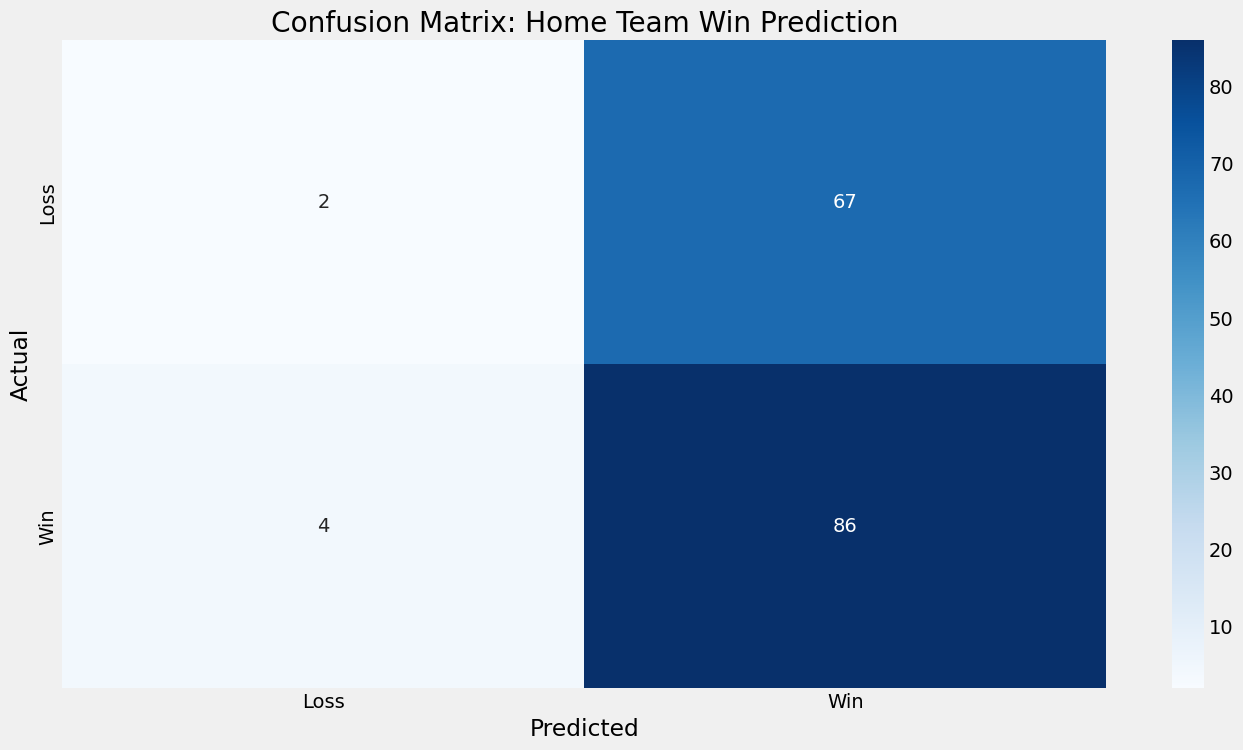

In [6]:
# 📊 Confusion matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
plt.title("Confusion Matrix: Home Team Win Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
# 🔍 Predict a specific matchup (example)

def predict_matchup(home_team, away_team):
    home = stats[stats["team"] == home_team].iloc[0]
    away = stats[stats["team"] == away_team].iloc[0]

    data = {
        "ppa_diff": home["offense_ppa"] - away["defense_ppa"],
        "ppa_allowed_diff": home["defense_ppa"] - away["offense_ppa"],
        "successRate_diff": home["offense_successRate"] - away["defense_successRate"],
        "successRate_allowed_diff": home["defense_successRate"] - away["offense_successRate"]
    }

    input_df = pd.DataFrame([data])
    prob = model.predict_proba(input_df)[0][1]
    print(f"Probability {home_team} beats {away_team}: {prob:.2%}")

# Example
predict_matchup("Michigan", "Ohio State")


Probability Michigan beats Ohio State: 62.14%


In [ ]:
# ✅ Summary

# In this notebook, you:
# - Joined team stats with game outcomes
# - Built a basic logistic regression model using stat differentials
# - Predicted outcomes and evaluated model accuracy
# - Created a reusable function to simulate future matchups

# 🧪 Try This:
# - Add features like talent composite, pass/rush rate, tempo
# - Use different models (RandomForest, XGBoost)
# - Predict score differential instead of binary win/loss